In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [2]:
! pip install '/content/gdrive/My Drive/Dacon/HAI 2.0/eTaPR-1.12-py3-none-any.whl'
from TaPR_pkg import etapr

Processing ./gdrive/My Drive/Dacon/HAI 2.0/eTaPR-1.12-py3-none-any.whl


In [3]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [5]:
path = '/content/gdrive/My Drive/Dacon/HAI 2.0/'

path_train = path + 'training'
path_valid = path + 'validation'
path_test = path + 'testing'
path_submission = path + 'sample_submission.csv'

seed = 0
np.random.seed(seed)

In [28]:
########################################################################################### basic functions
def get_progressbar_str(progress):
    MAX_LEN = 30
    BAR_LEN = int(MAX_LEN * progress)
    return ('Progress:[' + '=' * BAR_LEN +
            ('>' if BAR_LEN < MAX_LEN else '') +
            ' ' * (MAX_LEN - BAR_LEN) +
            '] %.1f%%' % (progress * 100.))
def put_labels(submission):
    temp = np.zeros_like(submission, dtype = 'int8')
    temp[submission < 0] = 1
    return temp
def check_graph(xs, att, piece=2, THRESHOLD=None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak )
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
    plt.show()

In [8]:
########################################################################################### data preparation basic functions
def read_train(path):
    file_paths = glob.glob(path+'/*.csv')
    df = pd.DataFrame()
    for file in file_paths:
        f=pd.read_csv(file)
        df = df.append(f, ignore_index=True)
    # make C01 ~ C79 list
    C_cols = list(df.columns)
    C_cols.remove('time')
    return df[C_cols].values, C_cols

def read_test(path, C_cols):
    file_paths = glob.glob(path+'/*.csv')
    df = pd.DataFrame()
    for file in file_paths:
        f=pd.read_csv(file)
        df = df.append(f, ignore_index=True)
    label = None
    if 'attack' in df.columns:
        label = df['attack'].values
    return df[C_cols].values, label

train, C_cols = read_train(path_train)
valid, valid_label = read_test(path_valid, C_cols)
test, _ = read_test(path_test, C_cols)

print(train.shape, valid.shape, test.shape)

NameError: ignored

In [14]:
print(train.shape, valid.shape, test.shape)

(921603, 79) (43201, 79) (358804, 79)


In [ ]:
model = IsolationForest(max_samples = 1.0, n_estimators = 1000, n_jobs = -1, verbose = 1, warm_start = True)
model.fit(train)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


In [25]:
val_res = model.predict(valid)

In [26]:
val_res

array([ 1,  1,  1, ..., -1, -1, -1])

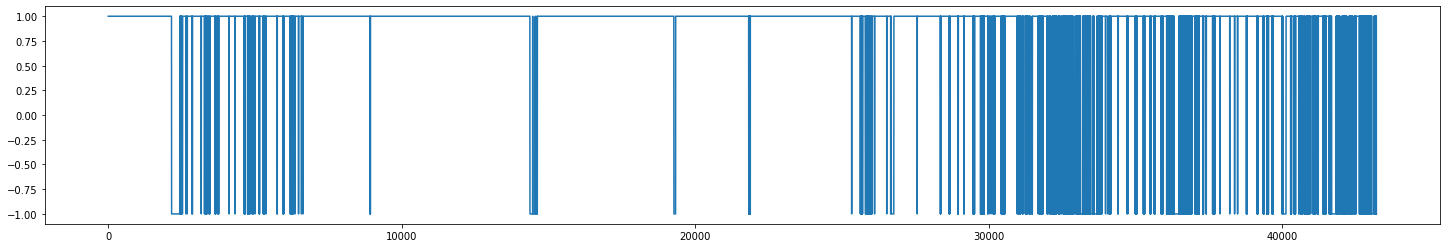

In [27]:
plt.rcParams['figure.figsize'] = [25, 4]
plt.plot(val_res)

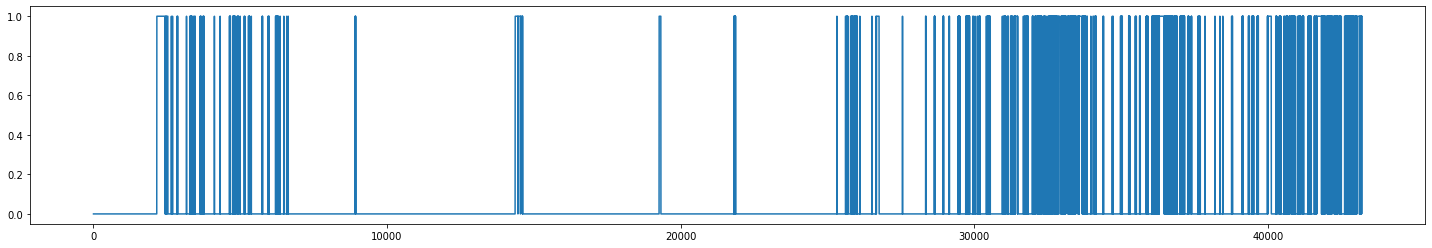

In [30]:
val_label = put_labels(val_res)
plt.rcParams['figure.figsize'] = [25, 4]
plt.plot(val_label)

In [31]:
TaPR = etapr.evaluate(anomalies=valid_label, predictions=val_label)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.088 (TaP: 0.047, TaR: 0.832)
# of detected anomalies: 5
Detected anomalies: ['1', '2', '3', '4', '5']


In [ ]:
test_res = model.predict(test)